# Barest Soil 

### Fei Zhang @Geoscience Australia

Last Updated  Sept 2016

## Introduction

Find the barest soil Earth observations from time series analysis. The result data  will be used as input for the mineral resources uncover project:  machine-learning application.

Here are the centre point locations for 3 study aread with different vegetation/bareness relationships;

1. Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E

2. Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E

3. Woodland (remain greenish most of the time - the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E

extract a 5X5 km or 10X10km tile for each area. Then select only tiles with < 10% poor quality pixels (e.g. noise , cloud etc.). From that subset we run NDVI and then run a median kernel (3*3 ?) to smooth out noisy pixels. The kernel needs to accommodate crappy pixels as no data values. After that we calculate the average NDVI response for whole the tile. We should try a keep the tiles in chronological order because when we process all the tiles through time series and plot up the average NDVI value for each tile we will want to see trends of drying out (increased bareness) due to seasonal effects or recovery from fire scars. I suggest we look at the image tiles along each step of the work flow. There are lots of parameters (size of tile, size and shape of the kernel etc) we can change  - but as a first step this might be a good start. 

Fei we might want to have further discussions when you have selected a sub-group of tiles with good pixel quality. I suppose this first step assumes that we have a very good pixel quality mask or flag?
We have significant temporal depth - so if in doubt exclude problematic tiles.





## Interactive Computing Environment

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pandas

import sys
sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2')#'/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

In [2]:
# import AGDC Python API modules

import datacube
from datacube.storage import masking

# Create an API data access object
dc = datacube.Datacube(app='BarestSoil')

dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://fxz547@130.56.244.227:6432/datacube)>>>

We can access the Postgres Database (metadata index) and its associated imagery data.

## Retrieving Sensor Data and Compute New Features (Constructed Variables)

### Band maths: combine the bands to derive new variables (artificial bands)

-  Normalized Difference Vegetation Index, NDVI
-  Normalized Difference Water Index,  NDWI
-  These index can help to clearly identify certain land cover features: Vegetation, water bodies

### Must identify and remove invalid observations: cloud, shadow, satuared pixels

In [3]:
#masking.make_mask?

In [4]:
def get_ndvi(prod_type, xp, yp, tp,  cloudfreeRatio = 0.5):
    
    blist= ['red', 'nir'] #, 'green', 'swir1']
    bands = dc.load(product=prod_type, x=xp, y=yp, time=tp, measurements= blist, group_by='solar_day')
    
    bands = masking.mask_valid_data(bands)
    red= bands.red
    nir= bands.nir
# or
    #red = bands.red.where(bands.red != bands.red.attrs['nodata'])
    #nir = bands.nir.where(bands.nir != bands.nir.attrs['nodata']) 
    # green = bands.green.where(bands.green != bands.green.attrs['nodata'])
    # swir1 = bands.swir1.where(bands.swir1 != bands.swir1.attrs['nodata'])
# Or equivalently    
#     red= masking.mask_valid_data(bands.red)
#     nir= masking.mask_valid_data(bands.nir)
   

    # Retrieve the associated Pixel Quality datasets ls8_pq_albers
    pq_prod_type = prod_type.replace('nbar','pq')
    pq = dc.load(product=pq_prod_type, x=xp, y=yp,  time=tp, group_by='solar_day')

    print ("NBAR and PQ slices: %s %s"%(len(bands.time), len(pq.time)))

    # to get perfect good pixels, how about cloud shadows?
    cloud_free = masking.make_mask(pq, cloud_acca='no_cloud',  cloud_fmask='no_cloud', 
                                   cloud_shadow_acca = 'no_cloud_shadow',cloud_shadow_fmask = 'no_cloud_shadow',contiguous=True).pixelquality
    
# cloud_acca='no_cloud',cloud_fmask='no_cloud', cloud_shadow_acca = 'no_cloud_shadow',cloud_shadow_fmask = 'no_cloud_shadow',
                              
    # Normalized Differenc Vegetation Index: Red and near Infrared bands

    print(cloud_free)
    red1=red.where(cloud_free)
    nir1=nir.where(cloud_free)
    ndvi = ((nir1 - red1) / (nir1 + red1)) #.where(cloud_free)  ?

    # Normalized Differenc Water Index: Green and Shortwave Infrared Bands

    #ndwi = ((swir1- green)/(green + swir1)).where(cloud_free)

    #ndwi = ((green- swir1)/(green + swir1)).where(cloud_free)

    print("NDVI shape ", str(ndvi.shape))

    # xarray.Dataset.sum to reduce the datasets by selecting the time slices with high percentage cloud-free pixels
    #  Weed out the low quality images
    # cloudfreeRatio = 0.8  # threshold of cloud pixel 80%

    mostly_cloud_free = cloud_free.sum(dim=('x','y')) > (cloudfreeRatio * cloud_free.size / cloud_free.time.size)

    print(mostly_cloud_free)
    
    print("How many cloudless images selected?", mostly_cloud_free.sum().values)
    
    # Apply the time-dim mask to the 3D-array (time, x, y)
    mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')
    # mostly_good_ndvi.plot(col='time', col_wrap=5)
    
    print( mostly_good_ndvi)
    
    return mostly_good_ndvi

def get_ndvi_mean(mostly_good_ndvi):
    
    ndvi_mean=mostly_good_ndvi.mean(dim=['x','y'])  # average over the image pixels
    
    pdser=ndvi_mean.to_pandas()  # pd.Series
    
    
    df= pdser.to_frame(name='NDVI') # convert to dataframe
    
    df['PROD_TYPE']= prod_type  # add a new column
    
    return df



In [5]:
# Where?

# xp=(149.00, 149.20); yp=(-35.25, -35.35)  # Lake Burley Griffin x=(149.07, 149.17), y=(-35.25, -35.35), 
# xp=( 149.160,  149.170); yp=(-35.34 , -35.35 )  #a small area cover GA water pond


# Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E
# 0.1degree =~ 10km 
# AOI_NAME='FireScarNT'; xp=(132.50, 132.60); yp=(-19.65, -19.55)

#Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E
#AOI_NAME='Farmland'; xp=(148.14, 148.24); yp=(-30.15, -30.05) # North of Dubbo, inside NSW border

#Woodland (greenish most of the time. the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E
AOI_NAME='Woodland'; xp=(147.35, 147.45); yp=(-22.92, -22.82)  # west of Rockhampton 
# woodland has a blank image in 2016-05? with NDVI=0. how to exclude it?
                
# When? a time range
tp=('1980-01-01', '2016-12-31')


#To see the function signature?
#dc.load?


In [37]:
prod_type='ls5_nbar_albers'

pq_prod_type = prod_type.replace('nbar','pq')

good_ndvi=get_ndvi(prod_type, xp,yp,tp,cloudfreeRatio = 0.5)

print (good_ndvi.shape)

NBAR and PQ slices: 617 617
<xarray.DataArray 'pixelquality' (time: 617, y: 494, x: 458)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [

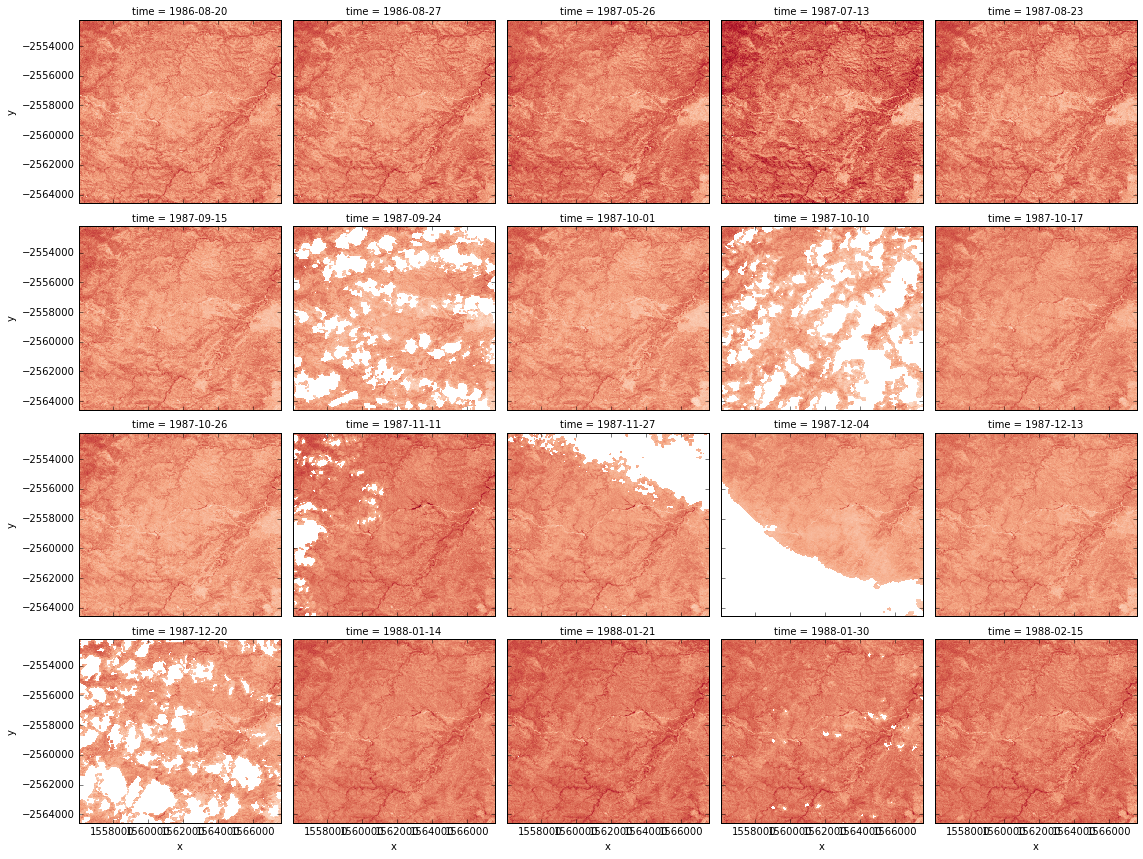

In [82]:
good_ndvi[:20].plot(col='time', col_wrap=5, add_colorbar=False)

In [39]:
#https://github.com/NICTA/uncover-ml/blob/develop/preprocessing/raster_average.py
    
from numpy.lib.stride_tricks import as_strided
def filter_center(A, size=3, no_data_val=None, func=np.nanmean):
    """
    Parameters
    ----------
    A = input data
    size = odd number uniform filtering kernel size
    no_data_val = value in matrix that is treated as no data value
    func: function to use, choose from np.nanmean/median/max/min etc.
    Returns: nanmean of the matrix A filtered by a uniform kernel of size=size
    -------
    Adapted from: http://stackoverflow.com/questions/23829097/python-numpy-fastest-method-for-2d-kernel-rank-filtering-on-masked-arrays-and-o?rq=1
    Notes
    -----
    This function `centers` the kernel at the target pixel.
    This is slightly different from scipy.ndimage.uniform_filter application.
    In scipy.ndimage.uniform_filter, a convolution approach is implemented.
    An equivalent is scipy.ndimage.uniform_filter like convolution approach with
    no_data_val/nan handling can be found in filter_broadcast_uniform_filter in
    this module.
    Change function to nanmedian, nanmax, nanmin as required.
    """

    assert size % 2 == 1, 'Please supply an odd size'
    rows, cols = A.shape

    padded_A = np.empty(shape=(rows + size-1,
                               cols + size-1),
                        dtype=A.dtype)
    padded_A[:] = np.nan
    rows_pad, cols_pad = padded_A.shape

    if no_data_val:
        mask = A == no_data_val
        A[mask] = np.nan

    padded_A[size//2:rows_pad - size//2, size//2: cols_pad - size//2] = A.copy()

    N, M = A.shape

    B = as_strided(padded_A, (N, M, size, size),
                   padded_A.strides+padded_A.strides)
    B = B.copy().reshape((N, M, size**2))
    return func(B, axis=2)

In [40]:
img1=good_ndvi[7]
#mask = ~np.isnan(img1); img1f = median(img1,disk(5), mask=mask)
img1f = filter_center(img1, size=3, func=np.nanmedian )

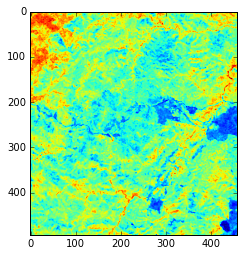

In [41]:
plt.imshow(img1f)


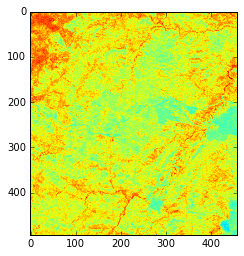

In [42]:
plt.imshow(img1)

In [43]:
np.nanmean(img1f)

0.36300013495988004

In [44]:
img1.mean()

<xarray.DataArray ()>
array(0.3631921650164337)
Coordinates:
    time     datetime64[ns] 1987-10-01

In [45]:
df_ndvi_ls8=get_ndvi_mean(good_ndvi)
df_ndvi_ls8.sort_values('NDVI').head(10)

,NDVI,PROD_TYPE
time,,
2009-11-30,0.276292,ls5_nbar_albers
1992-12-10,0.287775,ls5_nbar_albers
2008-10-26,0.288082,ls5_nbar_albers
1992-11-08,0.288893,ls5_nbar_albers
2009-12-09,0.289528,ls5_nbar_albers
1996-12-12,0.290112,ls5_nbar_albers
1992-12-01,0.293100,ls5_nbar_albers
2004-11-16,0.294003,ls5_nbar_albers
1994-12-16,0.302892,ls5_nbar_albers


In [46]:
# prod_type='ls7_nbar_albers'
# df_ndvi_ls7=get_ndvi_mean(good_ndvi)

# # ls5
# prod_type='ls5_nbar_albers'
# df_ndvi_ls5=get_ndvi_mean(good_ndvi)


In [47]:
# ndvi578=pandas.concat([df_ndvi_ls5, df_ndvi_ls7, df_ndvi_ls8])

# only Landsat-8

ndvi578 =df_ndvi_ls8

In [48]:
ndvi578.shape

(505, 2)

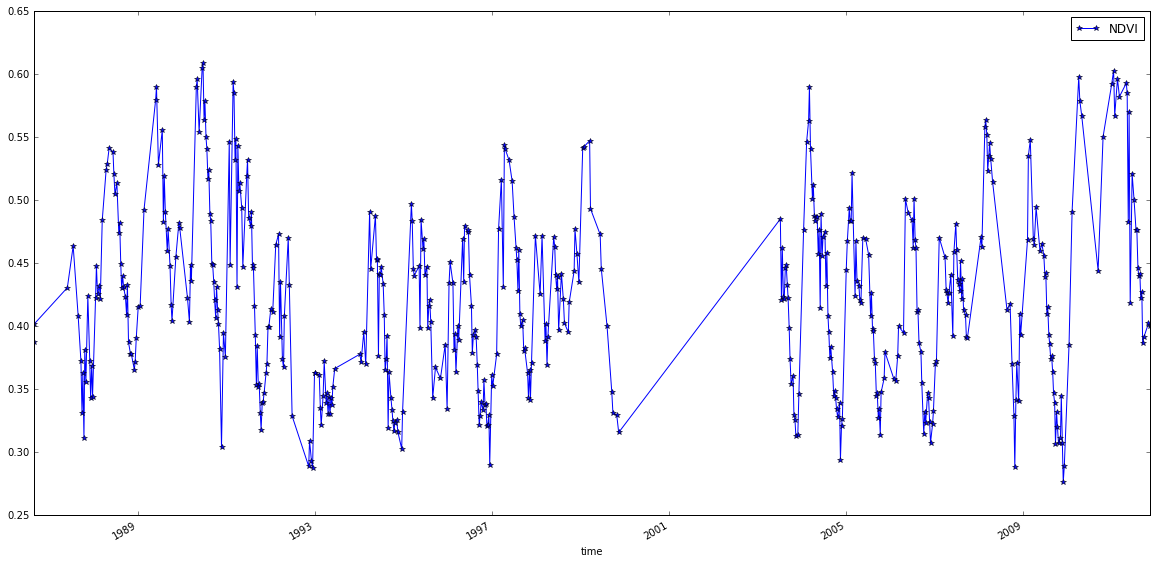

In [49]:

ndvi578.plot( figsize=(20,10),  marker='*' )

In [50]:
#ndvi_mean

In [51]:
outcsvfile='meanNDVI578_%s.csv'% (AOI_NAME)

ndvi578.to_csv(outcsvfile)  #('/tmp/meanNDVI578_FireScarNT.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e164dedd0>]], dtype=object)

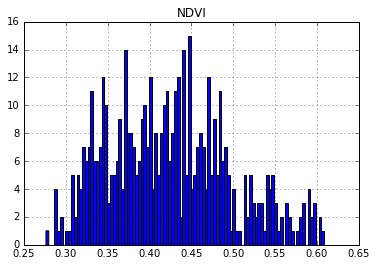

In [52]:
ndvi578.hist(bins=100)

In [53]:
p10= ndvi578.quantile(0.1)
p90= ndvi578.quantile(0.9)

bot_tenperc=ndvi578[(ndvi578['NDVI'] <= p10[0])].dropna()
top_tenperc=ndvi578[(ndvi578['NDVI'] >= p90[0])].dropna()

In [54]:
outcsvfile2='meanNDVI578_%s_bot10pc.csv'% (AOI_NAME)
bot_tenperc.to_csv(outcsvfile2)

outcsvfile3='meanNDVI578_%s_top10pc.csv'% (AOI_NAME)
top_tenperc.to_csv(outcsvfile3)

In [55]:
top_tenperc.head

<bound method DataFrame.head of                 NDVI        PROD_TYPE
time                                 
1988-05-05  0.541557  ls5_nbar_albers
1988-06-06  0.538117  ls5_nbar_albers
1989-05-24  0.579777  ls5_nbar_albers
1989-05-31  0.590165  ls5_nbar_albers
1989-07-18  0.555837  ls5_nbar_albers
1990-04-25  0.589937  ls5_nbar_albers
1990-05-02  0.596151  ls5_nbar_albers
1990-05-18  0.554166  ls5_nbar_albers
1990-06-12  0.604809  ls5_nbar_albers
1990-06-19  0.608791  ls5_nbar_albers
1990-06-28  0.563812  ls5_nbar_albers
1990-07-05  0.578573  ls5_nbar_albers
1990-07-14  0.550035  ls5_nbar_albers
1990-07-21  0.540869  ls5_nbar_albers
1991-01-22  0.546498  ls5_nbar_albers
1991-02-23  0.593734  ls5_nbar_albers
1991-03-02  0.585377  ls5_nbar_albers
1991-03-11  0.531863  ls5_nbar_albers
1991-03-18  0.548520  ls5_nbar_albers
1991-04-03  0.543499  ls5_nbar_albers
1991-06-22  0.532171  ls5_nbar_albers
1997-04-12  0.544262  ls5_nbar_albers
1997-04-19  0.540668  ls5_nbar_albers
1997-05-21  0.5317

In [56]:
p10

NDVI    0.331374
dtype: float64

In [57]:
bot_tenperc.head(100)

,NDVI,PROD_TYPE
time,,
1987-09-24,0.331186,ls5_nbar_albers
1987-10-10,0.311577,ls5_nbar_albers
1990-11-19,0.304481,ls5_nbar_albers
1991-10-12,0.318044,ls5_nbar_albers
1992-06-24,0.328885,ls5_nbar_albers
1992-11-08,0.288893,ls5_nbar_albers
1992-11-15,0.309312,ls5_nbar_albers
1992-12-01,0.293100,ls5_nbar_albers
1992-12-10,0.287775,ls5_nbar_albers


In [58]:
def filtered_ndvi_nanmean(ndvi_imgs, ndisk=5):
    """New spatial filter to the input ndvi_imgs array, which may have nan pixel values, 
    ndisk=5 is the default size of the  filter
    return a pandas dataframe of mean NDVI for the images.

    See http://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=local%20median%20filter
    """

    mydict={}
    for it in xrange(0, len(ndvi_imgs.time)):
        # apply median filter to get an image meds for this timeslice
        img=ndvi_imgs.isel(time=it)
        acqdate=ndvi_imgs.time[it].values
        
        meds =  filter_center(img, size= ndisk, func=np.nanmedian ) 
        #plt.imshow(meds)
        mydict.update({acqdate: np.nanmean(meds)})

    # convert mydict to pandas dataframe, with proper column names and index
    pdf=pandas.DataFrame(mydict.items(), columns=['Date', 'NDVI'])
    pdf.set_index('Date', inplace=True)
    
    return pdf

In [59]:
pdf5 = filtered_ndvi_nanmean( good_ndvi, ndisk=5)

pdf5.head()

,NDVI
Date,
1986-08-20,0.386787
1986-08-27,0.401449
2007-03-30,0.454481
1990-03-15,0.436154
2003-12-09,0.344667


In [72]:
ndvidf5 = pandas.merge(ndvi578, pdf5, left_index=True, right_index=True, how='outer')

,NDVI_x,PROD_TYPE,NDVI_y
1986-08-20,0.387415,ls5_nbar_albers,0.386787
1986-08-27,0.402076,ls5_nbar_albers,0.401449
1987-05-26,0.430757,ls5_nbar_albers,0.430851
1987-07-13,0.463808,ls5_nbar_albers,0.462792
1987-08-23,0.408564,ls5_nbar_albers,0.408307


In [73]:
ndvidf11 = pandas.merge(ndvidf5, spdf11, left_index=True, right_index=True, how='outer')

In [75]:
ndvidf11.head()

,NDVI_x,PROD_TYPE,NDVI_y,NDVI
1986-08-20,0.387415,ls5_nbar_albers,0.386787,0.386384
1986-08-27,0.402076,ls5_nbar_albers,0.401449,0.401108
1987-05-26,0.430757,ls5_nbar_albers,0.430851,0.431180
1987-07-13,0.463808,ls5_nbar_albers,0.462792,0.462656
1987-08-23,0.408564,ls5_nbar_albers,0.408307,0.408253


In [76]:
ndvidf21 = pandas.merge(ndvidf11, spdf21, left_index=True, right_index=True, how='outer')

In [77]:
ndvidf21.head()

,NDVI_x,PROD_TYPE,NDVI_y,NDVI_x,NDVI_y
1986-08-20,0.387415,ls5_nbar_albers,0.386787,0.386384,0.386113
1986-08-27,0.402076,ls5_nbar_albers,0.401449,0.401108,0.400893
1987-05-26,0.430757,ls5_nbar_albers,0.430851,0.431180,0.431453
1987-07-13,0.463808,ls5_nbar_albers,0.462792,0.462656,0.462912
1987-08-23,0.408564,ls5_nbar_albers,0.408307,0.408253,0.408297


In [80]:
new_cols = ['NDVI0', 'PROD_TYPE', 'NDVIS5', 'NDVIS11', 'NDVIS21']

ndvidf21.columns = new_cols

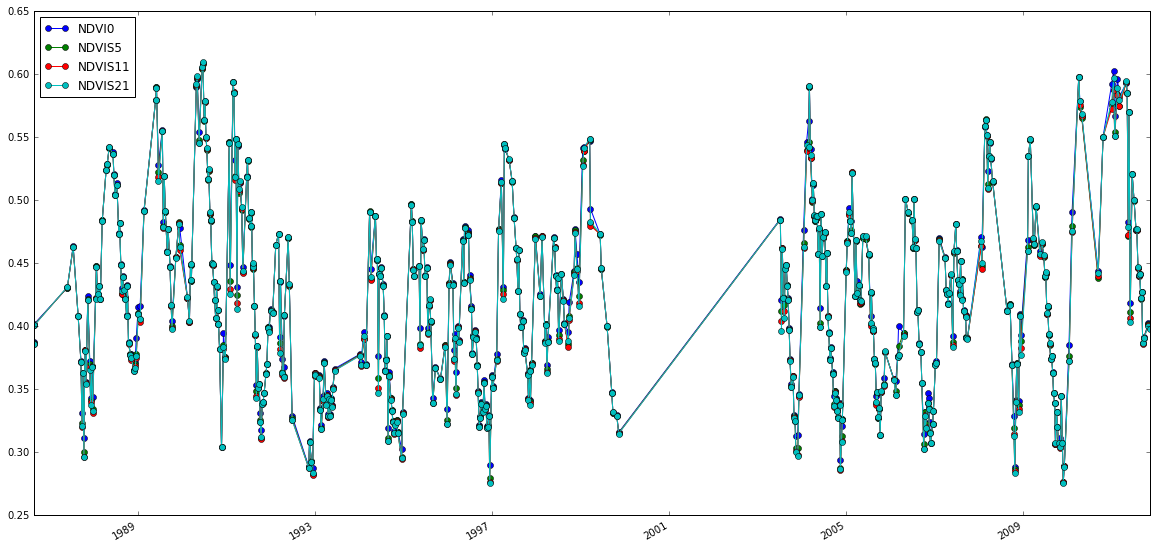

In [83]:
ndvidf21.plot(figsize=(20,10), marker='o' )

In [84]:
ndvidf21.to_csv("Woodland_LS5_NDVI.csv")

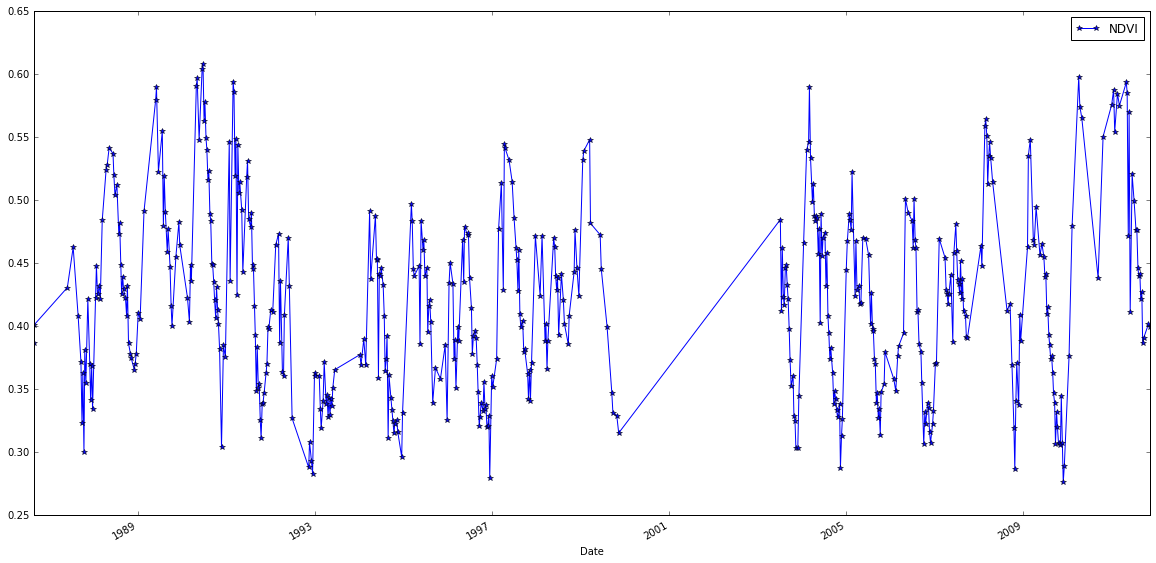

In [60]:
pdf5.plot(figsize=(20,10), marker='*' )

(505, 1)


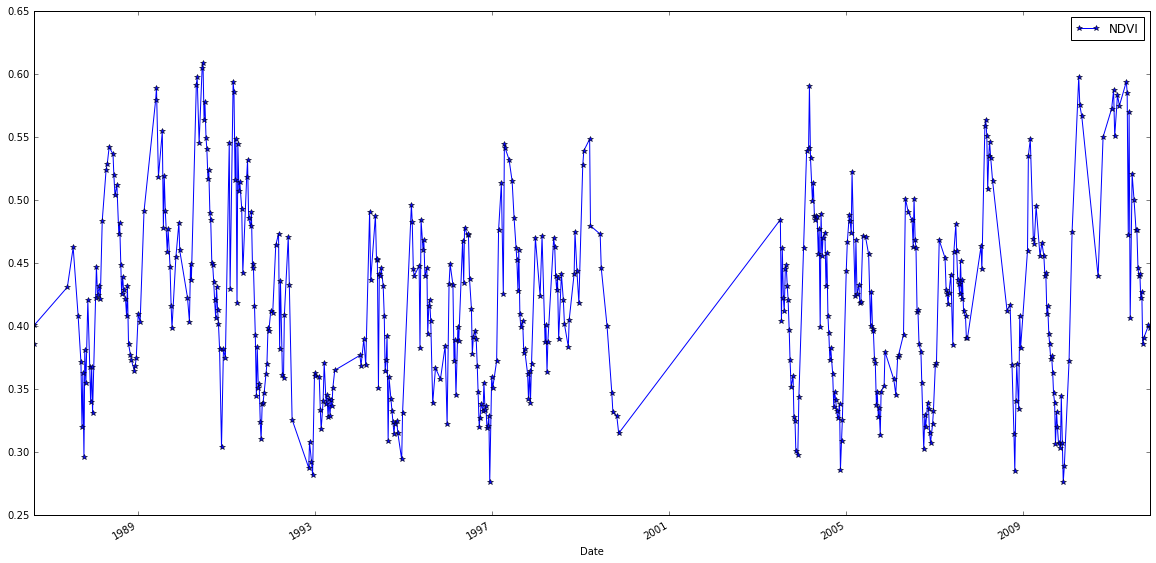

In [61]:
pdf10 = filtered_ndvi_nanmean( good_ndvi, ndisk=11)

print(pdf10.shape)

pdf10.plot(figsize=(20,10), marker='*' )

(505, 1)


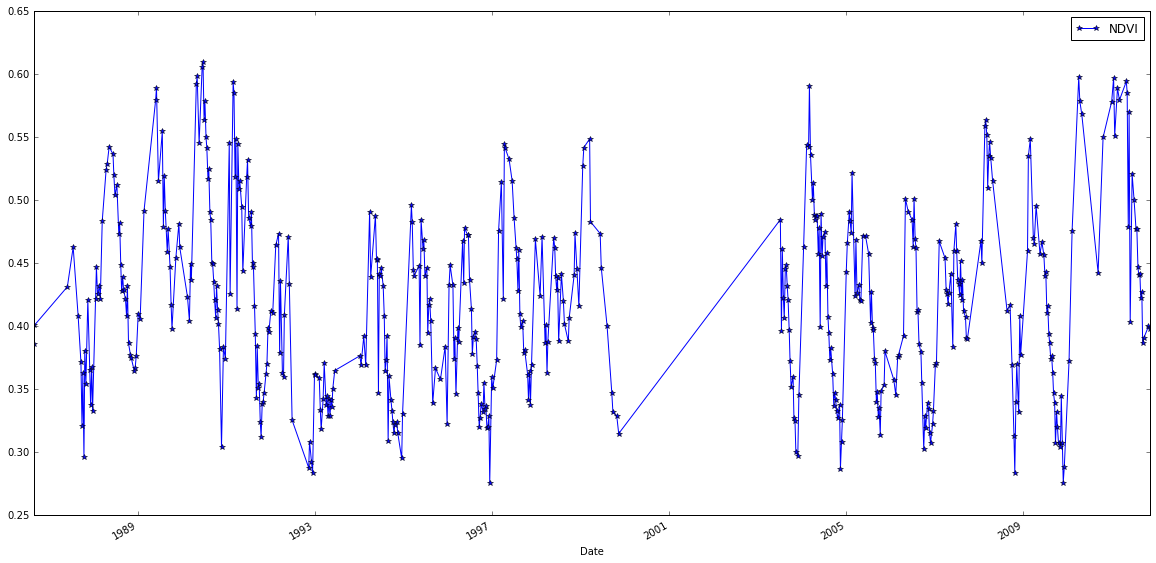

In [62]:
fsize=21
pdfn = filtered_ndvi_nanmean( good_ndvi, ndisk=fsize)

print(pdfn.shape)

pdfn.plot(figsize=(20,10), marker='*' )

In [63]:
spdf21=pdfn.sort_index()

In [64]:
spdf11=pdf10.sort_index()

In [65]:
spdf5=pdf5.sort_index()

In [66]:
for irow in xrange (0, pdf5.shape[0]):
    dtime=ndvi578.index[irow]
    print(dtime, ndvi578.iloc[irow][0], spdf5.iloc[irow].NDVI, spdf11.iloc[irow].NDVI,spdf21.iloc[irow].NDVI)

(Timestamp('1986-08-20 00:00:00'), 0.38741544875646317, 0.38678747493636823, 0.38638400954374835, 0.38611339711193071)
(Timestamp('1986-08-27 00:00:00'), 0.40207567761528151, 0.40144867373582199, 0.40110797165382051, 0.40089288921574057)
(Timestamp('1987-05-26 00:00:00'), 0.43075668812392021, 0.43085071122533097, 0.4311801817950987, 0.4314533058138858)
(Timestamp('1987-07-13 00:00:00'), 0.46380810939909284, 0.46279208090459534, 0.46265644931295868, 0.46291240404328665)
(Timestamp('1987-08-23 00:00:00'), 0.40856353482299662, 0.40830681108335998, 0.40825288220689582, 0.40829721811084002)
(Timestamp('1987-09-15 00:00:00'), 0.37241791307234551, 0.3720017792444516, 0.3717311386536265, 0.37155787585798883)
(Timestamp('1987-09-24 00:00:00'), 0.33118609514940084, 0.32326088332352487, 0.32018909921188105, 0.32108229868192584)
(Timestamp('1987-10-01 00:00:00'), 0.36319216501647966, 0.36287478811095053, 0.36270344481487127, 0.36267427401620128)
(Timestamp('1987-10-10 00:00:00'), 0.311577129506776

In [67]:
stop


NameError: name 'stop' is not defined

In [ ]:
#http://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=local%20median%20filter

from skimage import data
from skimage.morphology import disk
from skimage.filters.rank import median
# >>> img = data.camera()
# >>> med = median(img, disk(5))

In [ ]:
def filtered_ndvi_mean(ndvi_imgs, ndisk=5):
    """ apply a spatial filter to the input ndvi_imgs array
    return a pandas dataframe of mean NDVI for the images.
    ndisk=5 is the default size of the disk filter
    See http://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=local%20median%20filter
    """

    mydict={}
    for it in xrange(0, len(ndvi_imgs.time)):
        # apply median filter to get an image meds for this timeslice
        img=ndvi_imgs.isel(time=it)
        imask= ~np.isnan(img)
        meds = median(img,disk(ndisk), mask=imask)  
        #plt.imshow(meds)
        mydict.update({ndvi_imgs.time[it].values: meds.mean()})

    # convert mydict to pandas dataframe, with proper column names and index
    pdf=pandas.DataFrame(mydict.items(), columns=['Date', 'NDVI'])
    pdf.set_index('Date', inplace=True)
    
    return pdf

In [ ]:
scaled_good_ndvi = 128*(1+good_ndvi) # to unint8 or uint16 for scikit-image filter input

uint8_good_ndvi=scaled_good_ndvi.astype('uint8')

pdf5 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=5)

pdf5.head()

In [ ]:
pdf0=filtered_ndvi_mean( uint8_good_ndvi, ndisk=0)

In [ ]:
# plt.figure( )
pdf0.plot(figsize=(20,10), marker='*' )

In [ ]:
pdf5.plot(figsize=(20,10), marker='*' )

In [ ]:
pdf10 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=10)

print(pdf10.shape)
pdf10.plot(figsize=(20,10), marker='*' )

In [ ]:
pdf15 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=15)

print(pdf15.shape)
pdf15.plot(figsize=(20,10), marker='*' )

In [ ]:
pdf20 = filtered_ndvi_mean( uint8_good_ndvi, ndisk=20)

print(pdf15.shape)
pdf20.plot(figsize=(20,10), marker='*' )

In [ ]:
# no filter, original ndvi images
ndvi578.sort_values('NDVI').head(40)

In [ ]:

for irow in xrange (0, pdf5.shape[0]):
    dtime=ndvi578.index[irow]
    print(dtime,ndvi578.iloc[irow][0], pdf5.iloc[irow].NDVI, pdf10.iloc[irow].NDVI, pdf15.iloc[irow].NDVI, pdf20.iloc[irow].NDVI)

In [ ]:
bot_tenperc.head()

In [ ]:
(147.901603-128)/128

In [ ]:
pdf15.sort_values('NDVI').head(40)

In [ ]:
top_tenperc.head(5)

In [ ]:
done

## Normalised Difference Water Index

In [ ]:
# images after removed invalid pixels. 
#ndwi.plot(col='time', col_wrap=6)


### Weed out the low quality images.

In [ ]:
# apply the cloud_threshold mask, which will select a subset images with good pixels. 

mostly_good_ndwi = ndwi.where(mostly_cloud_free).dropna('time', how='all')

mostly_good_ndwi.plot(col='time', col_wrap=5)

## Statistics Median and Mean Images

### Normalised Vegetation Index vs Water Index

In [ ]:
plt.figure( figsize=(16,12) )
    
plt.subplot( 2,2,1 )
mostly_good_ndvi.median(dim='time').plot()
plt.title("Median Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi.mean(dim='time').plot()
# ndvi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')

#------------------------------
plt.subplot( 2,2,3 )
mostly_good_ndwi.median(dim='time').plot()
plt.title("Median Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,4 )
mostly_good_ndwi.mean(dim='time').plot()
# ndwi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')

# Water Observation from Space

http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm
